# ***KNN***

In [1]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)

import lime.lime_tabular

import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis

from model_evaluator import ModelEvaluator
me = ModelEvaluator([0,1,2])
from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [2]:
# LOAD DATA
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
model_filename = "../Models/best_knn_model.pkl"
study_filename = "../Study/optuna_study_KNN_nested.pkl"
metrics_filename = "../Models/best_knn_metrics.pkl"
fold_metrics_filename = "./Metrics/knn_folds_summary.csv"

In [4]:
# BUILD PIPELINE
def build_pipeline(params, numeric_features, categorical_features):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))]), categorical_features)
    ],
        verbose_feature_names_out=False,
        force_int_remainder_cols=False
        )
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(**params))
    ])
    return model

In [5]:
# OPTUNA INNER CV OPTIMIZATION
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 7, 30),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan"])
        }
        
        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            model.fit(X_t, y_t)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [6]:
# NESTED CV
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = me.evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = me.evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = me.evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = me.save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [7]:
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [8]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GRUPO', 'Cupo',
                                                   'dias_mora_Asignacion',
                                                   'saldo_total',
                                                   'Mora_maxima_cliente__Asignacion',
                                                   'situacion', 'Vencto',
                                                   'Priorizacion',
                                                   'Priorizacion_mes_anterior',
                                                   'CONTE...
                                                                                 sparse_output=False))]),
                                                  ['Rango',
                                                   'Tipo_producto_asignacion',
                                                   'FRANJA_REAL_MAX', 'ZONA',
                                                   'Tipo_Normalizacion',
                                                   'Oficina', 'Tipo_Linea_1',
                                                   'Arquetipos',
                                                   'Ultimo_Canal_Gestion',
                                                   'CR_Ultima_Gestion_Cliente',
                                                   'CR_Mejor_Gestion_Cliente',
                                                   'NumeroCuotas'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7,
                                      weights='distance'))])

In [9]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      3426
           1       0.69      0.56      0.62      1034
           2       0.67      0.40      0.50       625

    accuracy                           0.81      5085
   macro avg       0.74      0.64      0.67      5085
weighted avg       0.79      0.81      0.79      5085



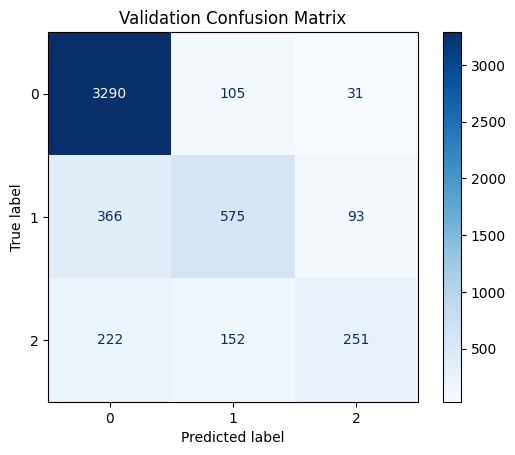

In [10]:
me.plot_confusion_matrix(metrics['confusion_matrix_val'], "Validation Confusion Matrix")

In [11]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      4281
           1       0.72      0.55      0.63      1293
           2       0.67      0.41      0.51       782

    accuracy                           0.81      6356
   macro avg       0.74      0.64      0.68      6356
weighted avg       0.80      0.81      0.80      6356



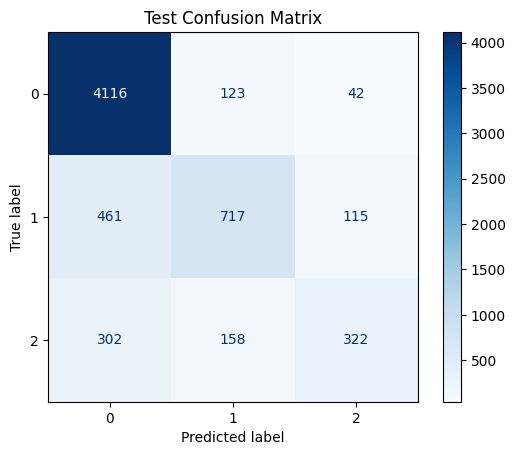

In [12]:
me.plot_confusion_matrix(metrics['confusion_matrix_test'], "Test Confusion Matrix")

--- Explanation for class 0 ---


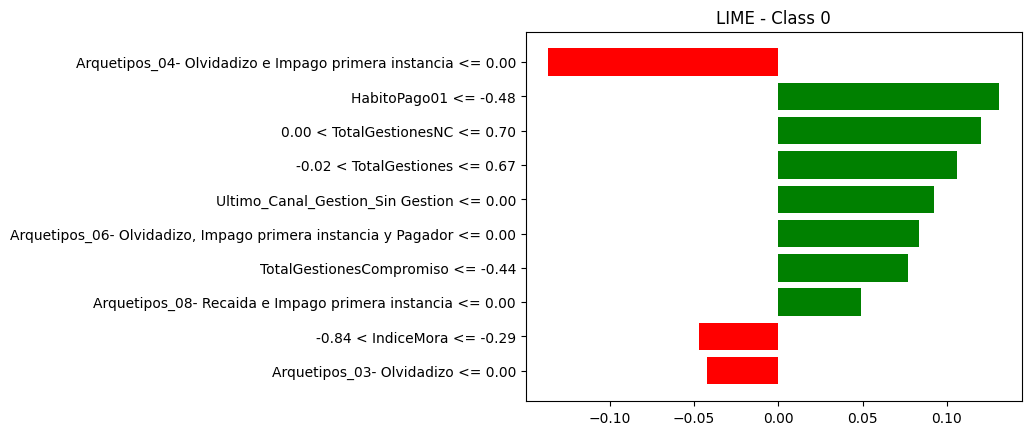

--- Explanation for class 1 ---


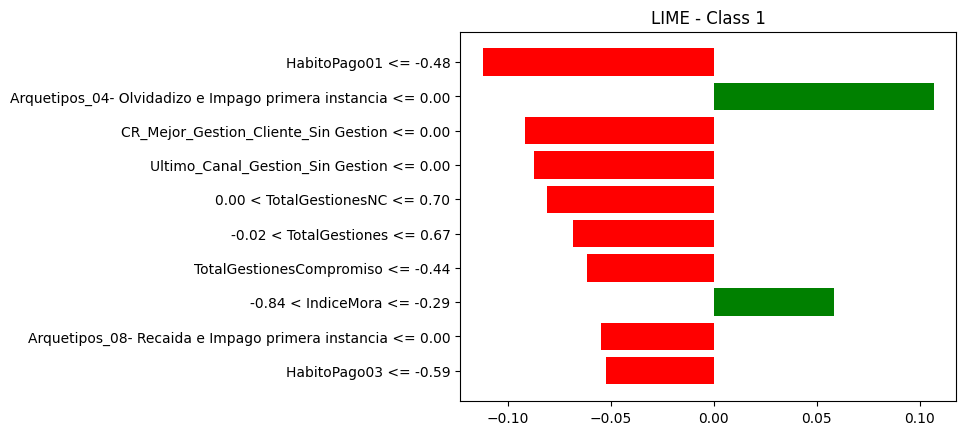

--- Explanation for class 2 ---


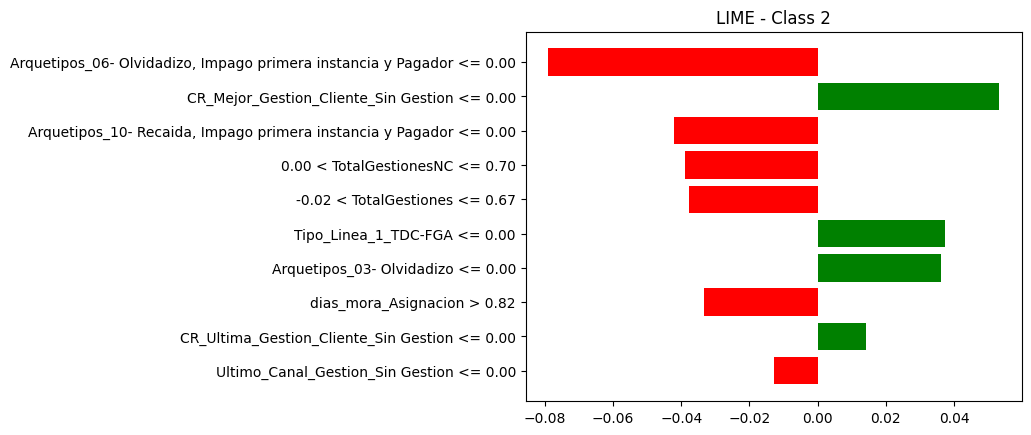

In [13]:
# LIME EXPLANATION FOR KNN
X_transformed = model.named_steps["preprocessor"].transform(metrics['X_train_fold'])
def predict_fn(x):
    return model.named_steps["classifier"].predict_proba(x)

feature_names = model.named_steps["preprocessor"].get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)
instance = X_transformed[10]

exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])
exp.show_in_notebook(show_table=True)
for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [14]:
visualizations['optimization_history']

In [15]:
visualizations['parallel_coordinate']

In [16]:
visualizations['f1_score_evolution']

In [17]:
visualizations['param_importances']

In [18]:
reporte.save(metrics, model_name="KNN")


Report for model 'KNN' saved:
   → CSV: ./Metrics/Metrics_KNN.csv
   → JSON: ./Metrics/Metrics_KNN.json


In [19]:
df = reporte.load()


Loaded 8 report(s)


In [20]:
df.query("Model == 'KNN' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
132,KNN,val,0,0.848,0.96,0.901
133,KNN,val,1,0.691,0.556,0.616
134,KNN,val,2,0.669,0.402,0.502
135,KNN,val,macro avg,0.736,0.639,0.673
136,KNN,val,weighted avg,0.794,0.809,0.794


In [21]:
df.query("Model == 'KNN' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
138,KNN,test,0,0.844,0.961,0.899
139,KNN,test,1,0.718,0.555,0.626
140,KNN,test,2,0.672,0.412,0.511
141,KNN,test,macro avg,0.745,0.643,0.678
142,KNN,test,weighted avg,0.797,0.811,0.795


In [ ]:
df.query("Model == 'KNN' and auc != '-' and Type != 'train'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
131,KNN,train,1.0,0.0,1.0
137,KNN,val,0.809,1.883,0.9
143,KNN,test,0.811,1.926,0.894


In [23]:
df.query("Model == 'KNN' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
137,KNN,val,0.809,1.883,0.9


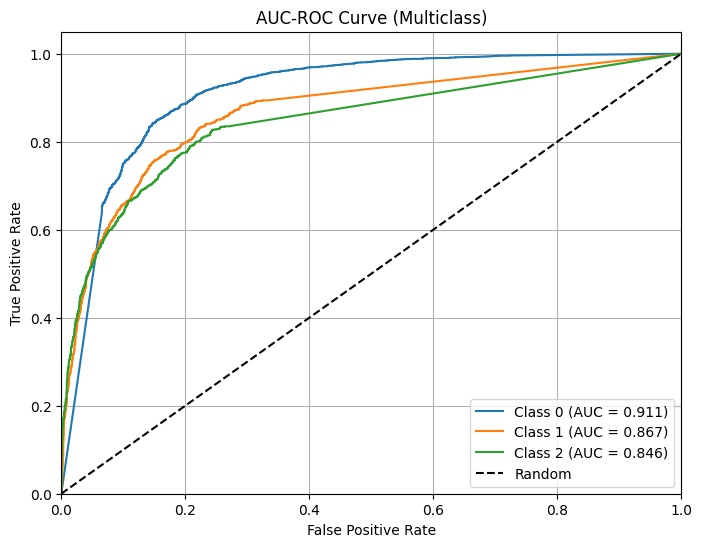

In [24]:
me.plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"]
)

In [25]:
model.named_steps['classifier'].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'distance'}